In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
from astropy.io import fits
# import aplpy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from radio_beam import Beam
from astropy.nddata.utils import Cutout2D
from pvextractor import Path
from pvextractor import extract_pv_slice
from spectral_cube import SpectralCube
from pvextractor import PathFromCenter
from astropy.coordinates import FK5

from matplotlib.ticker import MultipleLocator

import numpy as np
import astropy.units as u
from scipy import stats

plt.rcParams.update({"text.usetex": False,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in'})

In [25]:
file_vc_SO = 'Documents/SO/B335_SO_vlsr_3snr_HRA.fits'
#file_vc_SO = 'Documents/B335_SO_moment1.fits'
file_vc_N2Hp = 'Documents/B335_N2Hp_vlsr.fits'

file_dv_SO = 'Documents/SO/B335_SO_dv_3snr_HRA.fits'
file_dv_N2Hp = 'Documents/B335_N2Hp_dv.fits'
#file_dv_N2Hp = 'Documents/B335_N2Hp_dv_cubedirect.fits'

file_bright_SO = 'Documents/B335_SO_brightness.fits'

file_TdV_SO = 'Documents/B335_SO_TdV_clean.fits'
file_TdV_N2Hp = 'Documents/B335_N2H+_10_v1_Tpeak.fits'
file_TdV_CO = 'Documents/B335_CO_TdV.fits'
file_TdV_CO_2016 = 'Documents/B335_CO_TdV_2016.fits'

file_TdV_C18O = 'Documents/C18O/B335_C18O_mom0.fits'
file_vc_C18O = 'Documents/C18O/B335_C18O_vlsr_01kms_5snr.fits'
file_dv_C18O = 'Documents/C18O/B335_C18O_dv_01kms_5snr.fits'

file_vc_H13CO_blueshift = 'Documents/H13CO/B335_H13CO_32_vlsr_10snr_blueshift.fits'
file_dv_H13CO_blueshift = 'Documents/H13CO/B335_H13CO_32_dv_3snr_blueshift.fits'

file_TdV_H13CO = 'Documents/H13CO/B335_H13C0_32_mom0.fits'

file_vc_H13CO_redshift = 'Documents/H13CO/B335_H13CO_32_vlsr_5snr_redshift.fits'
file_dv_H13CO_redshift = 'Documents/H13CO/B335_H13CO_32_dv_5snr_redshift.fits'

file_vc_CS = 'Documents/CS/B335_CS_vlsr_3snr.fits'
file_dv_CS = 'Documents/CS/B335_CS_dv_3snr.fits'

file_cont_band3 = 'Documents/B335_cont_Band3.fits'
file_cont_band5 = 'Documents/B335_cont_Band5.fits'
file_cont_band6 = 'Documents/B335_cont_Band6.fits'
file_cont_band7 = 'Documents/B335_cont_Band7.fits'

file_cont = 'Documents/B335_cont.fits'

file_yso = 'Documents/B335.txt'

#ra0 = 044.9301
#dec0 = -06.5586
#width = 0.1010000
#height = 0.1150000

position = SkyCoord("19h37m0.9s","7d34m9.5s")
#position = SkyCoord(ra0 * u.deg, dec0 * u.deg, frame='fk5')
cutout_size_SO = u.Quantity((15.0, 15.0), u.arcsec)
#cutout_size_SO = u.Quantity((1.0, 1.0), u.arcsec)

cutout_size_C18O = u.Quantity((20.0, 20.0), u.arcsec)

cutout_size_N2Hp = u.Quantity((120.0, 120.0), u.arcsec)

cutout_size_H13CO = u.Quantity((40.0, 40.0), u.arcsec)

cutout_size = u.Quantity((2.0, 2.0), u.arcsec)

beam_pos_SO = SkyCoord("19h37m01.05s", "7d34m7.30s", frame='fk5')
scalebar_pos_SO = SkyCoord("19h37m00.79s", "7d34m11.75s", frame='fk5')

beam_pos_N2Hp = SkyCoord("19h37m04.3s", "7d33m20.0s", frame='fk5')
scalebar_pos_N2Hp = SkyCoord("19h36m58.5s", "7d35m0.0s", frame='fk5')

#col_pos = [0.55, 0.3, 0.3, 0.025]
col_pos = [0.67, 0.1, 0.3, 0.025]

levels_SO = np.arange(5, 200, 10) * 2.1e-3

levels_CO = np.arange(5, 200, 10) * 1.5 * 3.3e-3

#levels_CO = np.arange(3, 15, 1) * 5.66e-5
levels_C18O = np.arange(10, 200, 10) * 2.269e-3
levels_cont = np.arange(2, 40, 10) * 0.002
levels_cont_3 = np.arange(5, 200, 10) * 0.001
levels_cont_5 = np.arange(5, 200, 100) * 0.0001

rms_TdV_N2Hp = 0.5
levels_N2Hp = np.arange(2, 20, 2) * rms_TdV_N2Hp

vlsr = 8.34

xpos_lab1, ypos_lab1 = (0.05, 0.9)
xpos_lab2, ypos_lab2 = (0.05, 0.8)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

my_figsize = (5, 5)

ra_yso, dec_yso = np.loadtxt(file_yso, unpack=True)
marker_size = 50

In [26]:
distance = 164.5 # pc

def load_cutout(file_in, is_hdu=False):
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in
    # Make the cutout, including the WCS
    if Molecule=='SO':
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size_SO, wcs=WCS(hdu.header))
    elif Molecule=='N2Hp':
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size_N2Hp, wcs=WCS(hdu.header))
    elif Molecule=='C18O':
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size_C18O, wcs=WCS(hdu.header))
    elif Molecule=='H13CO':
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size_H13CO, wcs=WCS(hdu.header))
    else:
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_noema_wcsaxes(ax, hdu, label_col='black', contour_so=False, contour_cont=False, contour_n2hp=False, 
                             contour_co = False, contour_C18O = False):
    # ticks
    
    if Molecule == 'SO':
        ra_ax = ax.coords[0] # lon
        dec_ax = ax.coords[1] # lat
        ra_ax.set_major_formatter('hh:mm:ss.s')
        dec_ax.set_major_formatter('dd:mm:ss.s')
        ra_ax.display_minor_ticks(True)
        dec_ax.display_minor_ticks(True)
        ra_ax.set_ticks(spacing= 1.5 * u.arcsec, color=label_col)
        dec_ax.set_ticks(spacing= 1 * u.arcsec, color=label_col)
        ra_ax.set_minor_frequency(4)
        dec_ax.set_minor_frequency(4)
        ax.tick_params(which='major', length=6)
        ax.tick_params(which='minor', length=3)
        ax.autoscale(enable=False)
    
        ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='black', edgecolor='black',
                 linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))
    
    elif Molecule == 'N2Hp':
        ra_ax = ax.coords[0] # lon
        dec_ax = ax.coords[1] # lat
        ra_ax.set_major_formatter('hh:mm:ss.s')
        dec_ax.set_major_formatter('dd:mm:ss.s')
        ra_ax.display_minor_ticks(True)
        dec_ax.display_minor_ticks(True)
        ra_ax.set_ticks(spacing= 20 * u.arcsec, color=label_col)
        dec_ax.set_ticks(spacing= 20 * u.arcsec, color=label_col)
        ra_ax.set_minor_frequency(4)
        dec_ax.set_minor_frequency(4)
        ax.tick_params(which='major', length=6)
        ax.tick_params(which='minor', length=3)
        ax.autoscale(enable=False)
    
        ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='black', edgecolor='black',
                 linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))
        
    else:
        ra_ax = ax.coords[0] # lon
        dec_ax = ax.coords[1] # lat
        ra_ax.set_major_formatter('hh:mm:ss.s')
        dec_ax.set_major_formatter('dd:mm:ss.s')
        #ra_ax.display_minor_ticks(True)
        #dec_ax.display_minor_ticks(True)
        #ra_ax.set_ticks(spacing= 20 * u.arcsec, color=label_col)
        #dec_ax.set_ticks(spacing= 20 * u.arcsec, color=label_col)
        #ra_ax.set_minor_frequency(4)
        #dec_ax.set_minor_frequency(4)
        #ax.tick_params(which='major', length=6)
        #ax.tick_params(which='minor', length=3)
        #ax.autoscale(enable=False)
    
        ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='black', edgecolor='black',
                 linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))
        
    if contour_co:
        hdu_CO_TdV = load_cutout(file_TdV_CO)
        ax.contour(hdu_CO_TdV.data, levels=levels_CO, 
                   transform=ax.get_transform(WCS(hdu_CO_TdV.header)), 
                   colors='black', linewidths=1, alpha=0.5)
        
    if contour_so:
        hdu_SO_TdV = load_cutout(file_TdV_SO)
        ax.contour(hdu_SO_TdV.data, levels=levels_SO, 
                   transform=ax.get_transform(WCS(hdu_SO_TdV.header)), 
                   colors='black', linewidths=1, alpha=0.5)
    if contour_cont:
        hdu_cont_3 = load_cutout(file_cont_band3)
        ax.contour(hdu_cont_3.data, levels=levels_cont_3, 
                   transform=ax.get_transform(WCS(hdu_cont_3.header)), 
                   colors='white', linewidths=1, alpha=0.5)
        hdu_cont_5 = load_cutout(file_cont_band5)
        ax.contour(hdu_cont_5.data, levels=levels_cont_5, 
                   transform=ax.get_transform(WCS(hdu_cont_5.header)), 
                   colors='white', linestyles = 'dotted', linewidths=1, alpha=0.5)
        hdu_cont_7 = load_cutout(file_cont_band7)
        ax.contour(hdu_cont_7.data, levels=levels_cont, 
                   transform=ax.get_transform(WCS(hdu_cont_7.header)), 
                   colors='white', linestyles = 'dashed', 
                   linewidths=1, alpha=0.5)
        
    if contour_n2hp:
        hdu_n2hp = load_cutout(file_TdV_N2Hp)
        ax.contour(hdu_n2hp.data, levels=levels_N2Hp, 
                   transform=ax.get_transform(WCS(hdu_n2hp.header)), 
                   colors='black', linewidths=1, alpha=0.5)
        
    if contour_C18O:
        hdu_C18O = load_cutout(file_TdV_C18O)
        ax.contour(hdu_C18O.data, levels=levels_C18O, 
                   transform=ax.get_transform(WCS(hdu_C18O.header)), 
                   colors='black', linewidths=1, alpha=0.5)
        
    # Add beamsize
    
    if Molecule == 'SO':
        my_beam = Beam.from_fits_header(hdu.header)
        xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos_SO)
        pixscale = np.abs(hdu.header['cdelt1']) * u.deg
        ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
        ellipse_artist.set_color('black')
        _ = ax.add_artist(ellipse_artist)
    elif Molecule == 'N2Hp':
        my_beam = Beam.from_fits_header(hdu.header)
        xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos_N2Hp)
        pixscale = np.abs(hdu.header['cdelt1']) * u.deg
        ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
        ellipse_artist.set_color('black')
        _ = ax.add_artist(ellipse_artist)
        
    
    # Scalebar
    
    if Molecule == 'SO':
        length = (1e2*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
        ax.plot([scalebar_pos_SO.ra.deg, (scalebar_pos_SO.ra - length).deg]*u.deg,
            [(scalebar_pos_SO.dec).deg]*2*u.deg,
            'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
        ax.text((scalebar_pos_SO.ra - length / 2).deg, (scalebar_pos_SO.dec - 0.00004*u.deg).deg,
            "100 au", fontsize = 10, color='k', transform=ax.get_transform('fk5'), ha='center')
    elif Molecule == 'N2Hp':
        length = (2e3*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
        ax.plot([scalebar_pos_N2Hp.ra.deg, (scalebar_pos_N2Hp.ra - length).deg]*u.deg,
            [(scalebar_pos_N2Hp.dec).deg]*2*u.deg,
            'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
        ax.text((scalebar_pos_N2Hp.ra - length / 2).deg, (scalebar_pos_N2Hp.dec - 0.0012*u.deg).deg,
            "2000 au", color='k', transform=ax.get_transform('fk5'), ha='center')
        
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

# Continuum

Text(0.5, 1.0, 'Continuum Band 3/5/6/7')

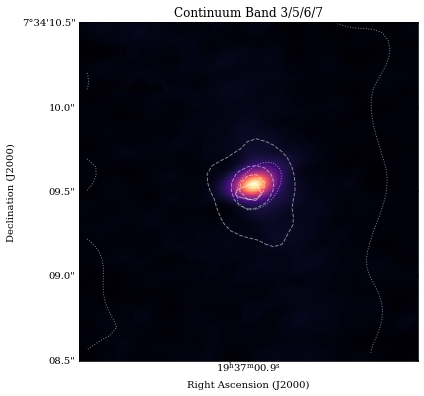

In [4]:
text_color = 'black'
Molecule = 'Continuum'

hdu = load_cutout(file_cont_band6)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_so=False, contour_cont=True)

#cax = ax.inset_axes(col_pos)
#cbar = plt.colorbar(im, cax=cax, label=r'(Jy/beam)', orientation='horizontal')
#cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'Continuum', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
plt.title('Continuum Band 3/5/6/7')
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

# SO Vlsr

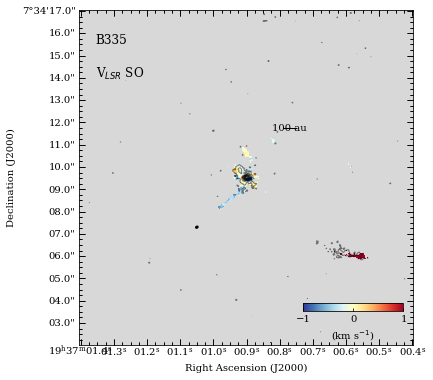

In [24]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_vc_SO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data - vlsr, vmin=-1, vmax=1, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_co = False, contour_cont=False, contour_so = True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ SO', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

#Center = SkyCoord("19h37m0.9s","7d34m9.5s")
#skypath = PathFromCenter(center=position, length = 2 * u.arcsec, angle = 45 * u.deg, width = 1)
#skypath.show_on_axis(ax, spacing=1, color='black')#, linestyle = 'dotted')

plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

# SO Channel maps

In [6]:
Cube_SO_vel = SpectralCube.read('Documents/Cube_SO_vel.fits')

#pvdiagram = extract_pv_slice(cube=Cube_SO_vel, path=skypath, spacing=1)

In [7]:
#pvdiagram.writeto("PVDiag_SO.fits", overwrite=True)

# SO TdV

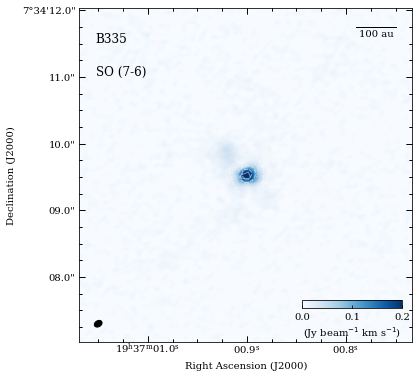

In [22]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_TdV_SO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin = 0, vmax = 0.2, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_cont=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'SO (7-6)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_SiO_TdV.pdf', dpi=200)

# SO dv

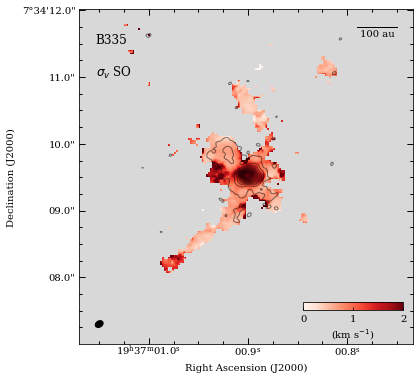

In [9]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_dv_SO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Reds').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin = 0, vmax = 2, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_so=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 1, 2])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$\sigma_{v}$ SO', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_N2Hp_dv_SiO.pdf', dpi=200)

# $N_2H+$ Vlsr

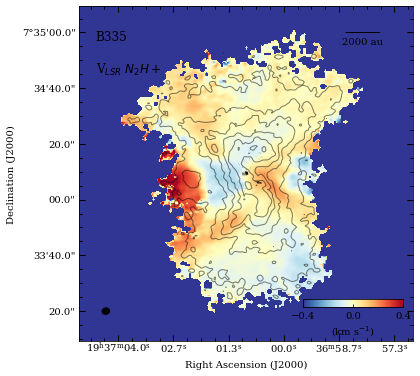

In [28]:
text_color = 'black'
Molecule = 'N2Hp'

hdu = load_cutout(file_vc_N2Hp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data - vlsr, vmin = -0.4, vmax= 0.4, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True, contour_co=False, contour_so = True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([-0.4,0,0.4])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ $N_2H+$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

# $N_2H+$ TdV

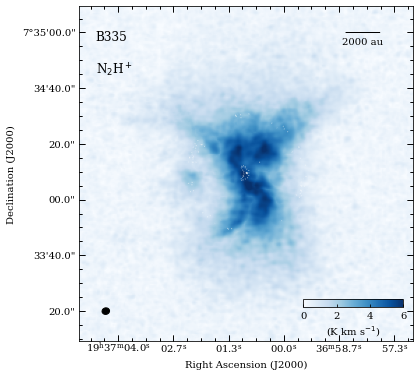

In [11]:
text_color = 'black'
Molecule = 'N2Hp'

hdu = load_cutout(file_TdV_N2Hp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin = 0, vmax = 6, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_cont=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 2, 4, 6])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'N$_2$H$^+$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_N2Hp_TdV.pdf', dpi=200)


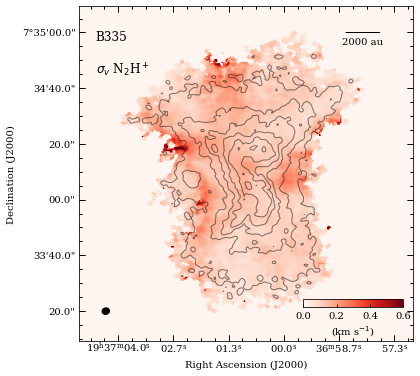

In [12]:
text_color = 'black'

hdu = load_cutout(file_dv_N2Hp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Reds').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin = 0, vmax = 0.6, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([0.2, 0.6, 1.0])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$\sigma_{v}$ N$_2$H$^+$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('Documents/Figures/B335_N2Hp_dv.png', dpi=200)

# CO TdV

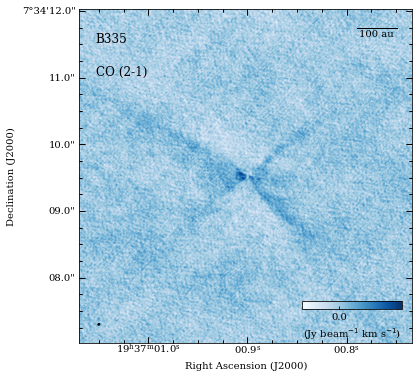

In [13]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_TdV_CO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_cont=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'CO (2-1)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_SiO_TdV.pdf', dpi=200)

# C18O TdV

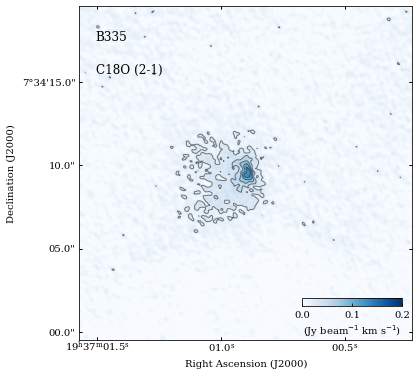

In [14]:
text_color = 'black'
Molecule = 'C18O'

hdu = load_cutout(file_TdV_C18O)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin = 0, vmax = 0.2, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_C18O=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([0, 0.1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C18O (2-1)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_SiO_TdV.pdf', dpi=200)

# C18O Vlsr

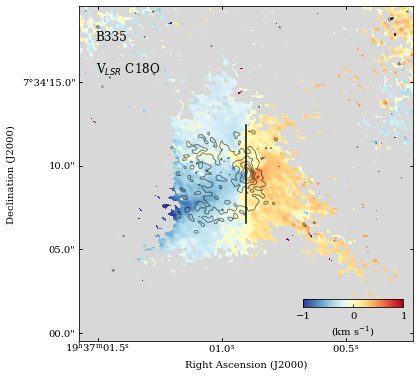

In [15]:
text_color = 'black'
Molecule = 'C18O'

hdu = load_cutout(file_vc_C18O)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data - vlsr, vmin=-1, vmax=1, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_C18O = True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ C18O', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

skypath = PathFromCenter(center=position, length = 6 * u.arcsec, angle = 0* u.deg)
skypath.show_on_axis(ax, spacing=1, color='black')#, linestyle = 'dotted')

plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

# H13CO 3-2 Vlsr

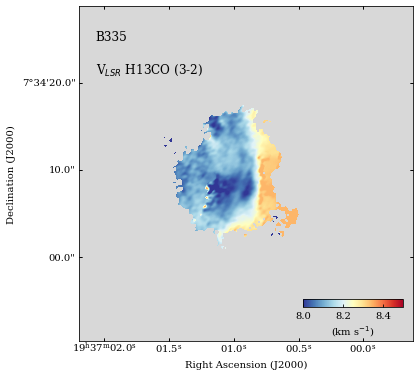

In [16]:
text_color = 'black'
Molecule = 'H13CO'

hdu = load_cutout(file_vc_H13CO_blueshift)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin = 8,vmax = 8.5, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_C18O = False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ H13CO+ (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

#skypath = PathFromCenter(center=position, length = 10 * u.arcsec, angle = 0* u.deg)
#skypath.show_on_axis(ax, spacing=1, color='black')#, linestyle = 'dotted')

plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

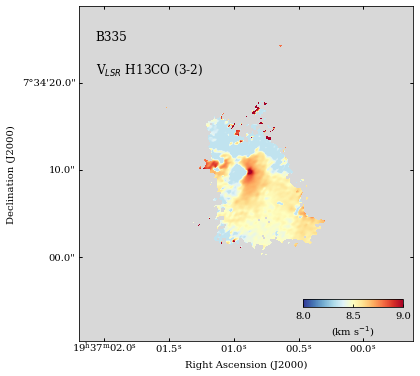

In [17]:
text_color = 'black'
Molecule = 'H13CO'

hdu = load_cutout(file_vc_H13CO_redshift)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin = 8,vmax =9,cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_C18O = False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ H13CO (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

#skypath = PathFromCenter(center=position, length = 10 * u.arcsec, angle = 0* u.deg)
#skypath.show_on_axis(ax, spacing=1, color='black')#, linestyle = 'dotted')

plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

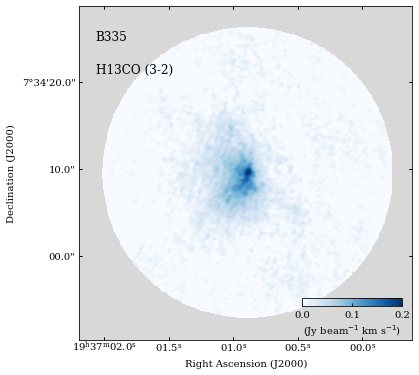

In [18]:
text_color = 'black'
Molecule = 'H13CO'

hdu = load_cutout(file_TdV_H13CO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin = 0, vmax = 0.2, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_cont=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H13CO (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_SiO_TdV.pdf', dpi=200)

# H13CO 3-2 dv

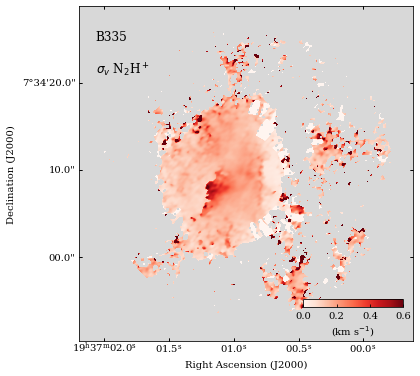

In [19]:
text_color = 'black'
Molecule = 'H13CO'

hdu = load_cutout(file_dv_H13CO_blueshift)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Reds').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin = 0, vmax = 0.6, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_n2hp=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([0.2, 0.6, 1.0])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$\sigma_{v}$ N$_2$H$^+$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('Documents/Figures/B335_N2Hp_dv.png', dpi=200)

# CS Vlsr

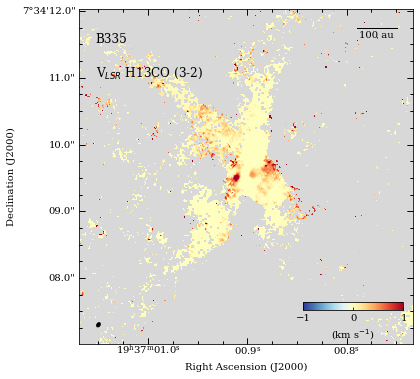

In [20]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_vc_CS)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data -vlsr, vmin = -1,vmax =1,cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_C18O = False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ H13CO (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

#skypath = PathFromCenter(center=position, length = 10 * u.arcsec, angle = 0* u.deg)
#skypath.show_on_axis(ax, spacing=1, color='black')#, linestyle = 'dotted')

plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)